# Deep Neural Network to Predict TB TFAs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchviz import make_dot


In [2]:
# # Set random seeds for reproducibility
# torch.manual_seed(42)
# np.random.seed(42)


# Load and preprocess the data


In [3]:
# Load gene expression data
try:
    expr_df = pd.read_csv('../data/gene-xprs/processed/xprs-data.csv')
    
    if expr_df.columns[0].lower() in ['unnamed: 0', 'index', 'sample', 'sample_id']:
        X_data = expr_df.iloc[:, 1:].values
    else:
        X_data = expr_df.values.T
except Exception as e:
    print(f"Error loading expression data: {e}")
    raise


In [4]:
# Load TFA data
try:
    tfa_df = pd.read_csv('../data/tfa/processed/tfa-labels.csv')
    y_data = tfa_df.values.T
except Exception as e:
    print(f"Error loading TFA data: {e}")
    raise


In [5]:
print(f"Original X_data shape: {X_data.shape}")
print(f"Original y_data shape: {y_data.shape}")

Original X_data shape: (3359, 3883)
Original y_data shape: (3359, 214)


In [6]:
# # TEMPORARY! Truncate TFA Matrix to have the same number of samples as the gene expression compendium
# min_samples = min(X_data.shape[0], y_data.shape[0])
# print(min_samples)
# X_data = X_data[:min_samples]
# y_data = y_data[:min_samples]

In [7]:

print(f"Final X_data shape: {X_data.shape}")
print(f"Final y_data shape: {y_data.shape}")


Final X_data shape: (3359, 3883)
Final y_data shape: (3359, 214)


In [8]:

# Scale the features and targets
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_data)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_data)



# Split data into training and testing sets

In [9]:

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)


In [10]:

print(f"Training set shape: X: {X_train.shape}, y: {y_train.shape}")
print(f"Testing set shape: X: {X_test.shape}, y: {y_test.shape}")


Training set shape: X: (2687, 3883), y: (2687, 214)
Testing set shape: X: (672, 3883), y: (672, 214)


In [11]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [12]:
mean = torch.mean(X_train_tensor)
std = torch.std(X_train_tensor)
min_val = torch.min(X_train_tensor)
max_val = torch.max(X_train_tensor)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"Minimum: {min_val}")
print(f"Maximum: {max_val}")

Mean: -0.002384757623076439
Standard Deviation: 1.0053199529647827
Minimum: -13.780862808227539
Maximum: 12.654417037963867


In [13]:
mean = torch.mean(y_train_tensor)
std = torch.std(y_train_tensor)
min_val = torch.min(y_train_tensor)
max_val = torch.max(y_train_tensor)

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"Minimum: {min_val}")
print(f"Maximum: {max_val}")

Mean: -0.00299310521222651
Standard Deviation: 1.0109002590179443
Minimum: -18.287635803222656
Maximum: 4.761702537536621


In [14]:

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


In [15]:

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Model Definition

In [16]:

class TFAPredictor(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[1024, 512, 256]):
        super(TFAPredictor, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        
        # Build the network
        layers = []
        
        # First hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.Tanh())
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.Dropout(0.3))
        
        # Additional hidden layers
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.Tanh())
            layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            layers.append(nn.Dropout(0.3))
        
        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Create sequential model
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        make_dot(self.model(x).mean(), params=dict(self.model.named_parameters()), show_attrs=True, show_saved=True)
        return self.model(x)



# Initialize model, loss function, and optimizer

In [17]:

input_size = X_train.shape[1]  # Number of samples
output_size = y_train.shape[1]  # Number of TFs


In [18]:
print(f"Input size: {input_size} genes")
print(f"Output size: {output_size} TF labels")

Input size: 3883 genes
Output size: 214 TF labels


In [19]:

model = TFAPredictor(input_size, output_size)
print(model)


TFAPredictor(
  (model): Sequential(
    (0): Linear(in_features=3883, out_features=1024, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
    (5): Tanh()
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): Tanh()
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=256, out_features=214, bias=True)
  )
)


In [20]:

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)



# Training function


In [21]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss



# Evaluation function

In [22]:
def evaluate(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(test_loader.dataset)
    return epoch_loss



# Training

In [23]:

num_epochs = 100
train_losses = []
test_losses = []

print("Training the model...")
for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    
    # Evaluate
    test_loss = evaluate(model, test_loader, criterion)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Training the model...
Epoch 5/100, Train Loss: 0.2027, Test Loss: 0.0693
Epoch 10/100, Train Loss: 0.1657, Test Loss: 0.0551
Epoch 15/100, Train Loss: 0.1508, Test Loss: 0.0556
Epoch 20/100, Train Loss: 0.1490, Test Loss: 0.0414
Epoch 25/100, Train Loss: 0.1450, Test Loss: 0.0407
Epoch 30/100, Train Loss: 0.1371, Test Loss: 0.0489
Epoch 35/100, Train Loss: 0.1334, Test Loss: 0.0388
Epoch 40/100, Train Loss: 0.1414, Test Loss: 0.0394
Epoch 45/100, Train Loss: 0.1447, Test Loss: 0.0401
Epoch 50/100, Train Loss: 0.1356, Test Loss: 0.0338
Epoch 55/100, Train Loss: 0.1320, Test Loss: 0.0344
Epoch 60/100, Train Loss: 0.1399, Test Loss: 0.0376
Epoch 65/100, Train Loss: 0.1349, Test Loss: 0.0356
Epoch 70/100, Train Loss: 0.1330, Test Loss: 0.0431
Epoch 75/100, Train Loss: 0.1280, Test Loss: 0.0359
Epoch 80/100, Train Loss: 0.1393, Test Loss: 0.0377
Epoch 85/100, Train Loss: 0.1214, Test Loss: 0.0436
Epoch 90/100, Train Loss: 0.1260, Test Loss: 0.0472
Epoch 95/100, Train Loss: 0.1248, Test Loss

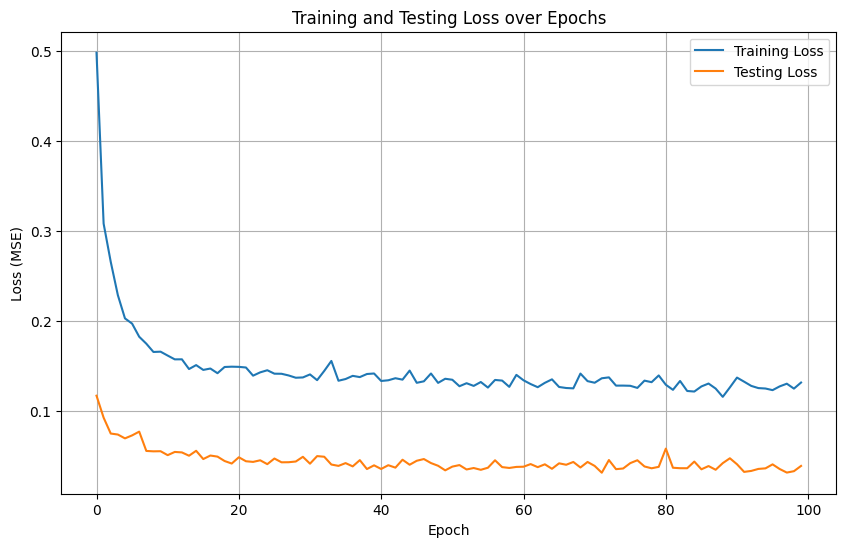

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()



# Evaluate test set


In [25]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    
print(f"Final test loss (MSE): {test_loss.item():.4f}")


Final test loss (MSE): 0.0387
